#### installs

In [4]:
# import sys
# !conda install --yes --prefix {sys.prefix} tqdm
# !conda install --yes --prefix {sys.prefix} tensorflow

Solving environment: ...working... done

## Package Plan ##

  environment location: F:\Anaconda3

  added / updated specs:
    - tqdm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.1.23  |                0         158 KB
    certifi-2019.3.9           |           py36_0         156 KB
    cryptography-2.6.1         |   py36h7a1dbc1_0         563 KB
    kiwisolver-1.0.1           |   py36h6538335_0          61 KB
    krb5-1.16.1                |       hc04afaa_7         819 KB
    libcurl-7.64.0             |       h2a8f88b_2         283 KB
    libpng-1.6.36              |       h2a8f88b_0         550 KB
    openssl-1.1.1b             |       he774522_1         5.7 MB
    pycurl-7.43.0.2            |   py36h7a1dbc1_0         182 KB
    pyqt-5.9.2                 |   py36h6538335_2         4.2 MB
    qt-5.9.7                   |   vc14h73c81de_0        92.3 MB
    

Solving environment: ...working... done

# All requested packages already installed.



In [ ]:
# import sys
# !conda install --yes --prefix {sys.prefix} ipdb

#### imports

In [2]:
from tqdm import tqdm

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import urllib
import sys
import os
import zipfile

#### Download Glove word embeddings

In [3]:
glove_zip_file = "data/glove.6B.zip"
glove_vectors_file = "data/glove.6B.100d.txt"
import zipfile, urllib.request, shutil, os
    
# #large file - 862 MB
# if (not os.path.isfile(glove_zip_file) and
#     not os.path.isfile(glove_vectors_file)):
#     with urllib.request.urlopen("http://nlp.stanford.edu/data/glove.6B.zip") as response, open(glove_zip_file, 'wb') as out_file:
#         shutil.copyfileobj(response, out_file)

Unzip word embeddings

In [6]:
def unzip_single_file(zip_file_name, output_file_name):
    """
        If the outFile is already created, don't recreate
        If the outFile does not exist, create it from the zipFile
    """
    if not os.path.isfile(output_file_name):
        with open(output_file_name, 'wb') as out_file:
            with zipfile.ZipFile(zip_file_name) as zipped:
                for info in zipped.infolist():
                    if output_file_name in info.filename:
                        with zipped.open(info) as requested_file:
                            out_file.write(requested_file.read())
                            return

unzip_single_file(glove_zip_file, glove_vectors_file)

In [9]:
glove_wordmap = {}
with open(glove_vectors_file, "r", encoding="utf8") as glove:
    for line in glove:
        name, vector = tuple(line.split(" ", 1))
        glove_wordmap[name] = np.fromstring(vector, sep=" ")

In [8]:
print(glove_wordmap)

{}


In [10]:
def sentence2sequence(sentence):
    """
     
    - Turns an input sentence into an (n,d) matrix, 
        where n is the number of tokens in the sentence
        and d is the number of dimensions each word vector has.
    
      Tensorflow doesn't need to be used here, as simply
      turning the sentence into a sequence based off our 
      mapping does not need the computational power that
      Tensorflow provides. Normal Python suffices for this task.
    """
    tokens = sentence.lower().split(" ")
    rows = []
    words = []
    #Greedy search for tokens
    for token in tokens:
        i = len(token)
        while len(token) > 0 and i > 0:
            word = token[:i]
            if word in glove_wordmap:
                rows.append(glove_wordmap[word])
                words.append(word)
                token = token[i:]
                i = len(token)
            else:
                i = i-1
    return rows, words

#### vis

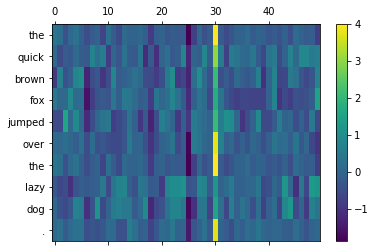

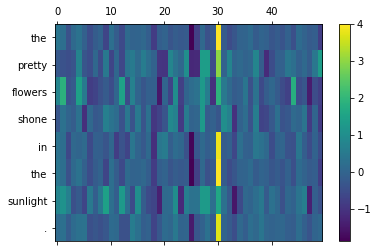

In [7]:
def visualize(sentence):
    rows, words = sentence2sequence(sentence)
    mat = np.vstack(rows)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    shown = ax.matshow(mat, aspect="auto")
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    fig.colorbar(shown)
    
    ax.set_yticklabels([""]+words)
    plt.show()
    
visualize("The quick brown fox jumped over the lazy dog.")
visualize("The pretty flowers shone in the sunlight.")

#### params

In [11]:



display_step = 10

def score_setup(row):
    convert_dict = {
      'ENTAILMENT': 0,
      'NEUTRAL': 1,
      'CONTRADICTION': 2
    }
    score = np.zeros((3,))
    tag = row["entailment_judgment"]
    score[convert_dict[tag]] += 1
    return score

def fit_to_size(matrix, shape):
    res = np.zeros(shape)
    slices = [slice(0,min(dim,shape[e])) for e, dim in enumerate(matrix.shape)]
    res[slices] = matrix[slices]
    return res

In [14]:
#Constants setup
max_hypothesis_length, max_evidence_length = 30, 30
batch_size, vector_size, hidden_size = 128, 100, 64

training_iterations_count = 100000

lstm_size = hidden_size

weight_decay = 0.0005

learning_rate = 1

input_p, output_p = 0.6, 0.3

[Training data](http://www.site.uottawa.ca/~diana/csi5386/A2_2019/SICK_train.txt)

In [15]:
import numpy as np

def split_data_into_scores():
    import csv
    with open("data/training.txt","r") as data:
        train = csv.DictReader(data , delimiter='\t')
        evi_sentences = []
        hyp_sentences = []
        labels = []
        scores = []
        count = 1
        for row in train:
            hyp_sentences.append(np.vstack(
                    sentence2sequence(row["sentence_A"].lower())[0]))
            evi_sentences.append(np.vstack(
                    sentence2sequence(row["sentence_B"].lower())[0]))
            labels.append(row["entailment_judgment"])
            scores.append(score_setup(row))
        
        hyp_sentences = np.stack([fit_to_size(x, (max_hypothesis_length, vector_size))
                          for x in hyp_sentences])
        evi_sentences = np.stack([fit_to_size(x, (max_evidence_length, vector_size))
                          for x in evi_sentences])
                                 
        return (hyp_sentences, evi_sentences), labels, np.array(scores)
data_feature_list, correct_values, correct_scores = split_data_into_scores()

l_h, l_e = max_hypothesis_length, max_evidence_length
N, D, H = batch_size, vector_size, hidden_size
l_seq = l_h + l_e

f:\python 36 64\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


### Cell used for development

In [12]:
def create_model():
    tf.reset_default_graph() 
    data_feature_list, correct_values, correct_scores = split_data_into_scores()

    l_h, l_e = max_hypothesis_length, max_evidence_length
    N, D, H = batch_size, vector_size, hidden_size
    l_seq = l_h + l_e
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    lstm_drop =  tf.contrib.rnn.DropoutWrapper(lstm, input_p, output_p)
    hyp = tf.placeholder(tf.float32, [N, l_h, D], 'hypothesis')
    evi = tf.placeholder(tf.float32, [N, l_e, D], 'evidence')
    y = tf.placeholder(tf.float32, [N, 3], 'label')
    lstm_back = tf.contrib.rnn.BasicLSTMCell(lstm_size)

    lstm_drop_back = tf.contrib.rnn.DropoutWrapper(lstm_back, input_p, output_p)

    fc_initializer = tf.random_normal_initializer(stddev=0.1) 
    fc_weight = tf.get_variable('fc_weight', [2*hidden_size, 3], 
                            initializer = fc_initializer)
    fc_bias = tf.get_variable('bias', [3])
    tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, 
                     tf.nn.l2_loss(fc_weight)) 

    x = tf.concat([hyp, evi], 1) # N, (Lh+Le), d
    x = tf.transpose(x, [1, 0, 2]) # (Le+Lh), N, d
    x = tf.reshape(x, [-1, vector_size]) # (Le+Lh)*N, d
    x = tf.split(x, l_seq,)
    rnn_outputs, _, _ = tf.contrib.rnn.static_bidirectional_rnn(lstm, lstm_back,
                                                            x, dtype=tf.float32)

    classification_scores = tf.matmul(rnn_outputs[-1], fc_weight) + fc_bias

    with tf.variable_scope('Accuracy'):
        predicts = tf.cast(tf.argmax(classification_scores, 1), 'int32')
        y_label = tf.cast(tf.argmax(y, 1), 'int32')
        corrects = tf.equal(predicts, y_label)
        num_corrects = tf.reduce_sum(tf.cast(corrects, tf.float32))
        accuracy = tf.reduce_mean(tf.cast(corrects, tf.float32))

    with tf.variable_scope("loss"):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
            logits = classification_scores, labels = y)
        loss = tf.reduce_mean(cross_entropy)
        total_loss = loss + weight_decay * tf.add_n(
            tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

    optimizer = tf.train.GradientDescentOptimizer(learning_rate)

    opt_op = optimizer.minimize(total_loss)
    # Initialize variables
    init = tf.global_variables_initializer()

    # Use TQDM if installed
    tqdm_installed = False
    try:
        from tqdm import tqdm
        tqdm_installed = True
    except:
        pass

    # Launch the Tensorflow session
    sess = tf.Session()
    sess.run(init)

    # training_iterations_count: The number of data pieces to train on in total
    # batch_size: The number of data pieces per batch
    training_iterations = range(0,training_iterations_count,batch_size)
    if tqdm_installed:
        # Add a progress bar if TQDM is installed
        training_iterations = tqdm(training_iterations)

    for i in training_iterations:
        if i % 1000 == 0:
        # Select indices for a random data subset
            batch = np.random.randint(data_feature_list[0].shape[0], size=batch_size)

        # Use the selected subset indices to initialize the graph's 
        #   placeholder values
        hyps, evis, ys = (data_feature_list[0][batch,:],
                          data_feature_list[1][batch,:],
                          correct_scores[batch])

        # Run the optimization with these initialized values
        sess.run([opt_op], feed_dict={hyp: hyps, evi: evis, y: ys})
        # display_step: how often the accuracy and loss should 
        #   be tested and displayed.
        if (i/batch_size) % display_step == 0:
            # Calculate batch accuracy
            acc = sess.run(accuracy, feed_dict={hyp: hyps, evi: evis, y: ys})
            # Calculate batch loss
            tmp_loss = sess.run(loss, feed_dict={hyp: hyps, evi: evis, y: ys})
            # Display results
            print("Iter " + str(i/batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(tmp_loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))

    data_feature_list, correct_values, correct_scores = split_test_data_into_scores("data/dev.txt")


    hyps, evis, ys = (data_feature_list[0][:],
                      data_feature_list[1][:],
                      correct_scores)
    predictions = sess.run(classification_scores, feed_dict={hyp: hyps, evi: evis, y: ys})
    total = len(predictions)
    correct_predictions = 0
    for i,prediction in enumerate(predictions):
        if np.argmax(prediction[0])==np.argmax(ys[i]):
            correct_predictions += 1
    #     print(["Positive", "Neutral", "Negative"][np.argmax(prediction[0])]+
    #       " / " + ["Positive", "Neutral", "Negative"][np.argmax(ys[i])])
    acc = correct_predictions*100/total
    print("Acc: %s" % str(acc))
    return acc

In [13]:
import numpy as np
accs = [] # 128
batches = [128, 64, 32, 1, 256]
for batch in batches:
    batch_size = batch
    accs.append(create_model())

print(accs)
print("Best batch size %s" % str(batches[np.argmax(accs)]))


ValueError: need at least one array to concatenate

### TRAINING

In [16]:
tf.reset_default_graph()

In [17]:
lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
lstm_drop =  tf.contrib.rnn.DropoutWrapper(lstm, input_p, output_p)

In [18]:
# N: The number of elements in each of our batches, 
#   which we use to train subsets of data for efficiency's sake.
# l_h: The maximum length of a hypothesis, or the second sentence.  This is
#   used because training an RNN is extraordinarily difficult without 
#   rolling it out to a fixed length.
# l_e: The maximum length of evidence, the first sentence.  This is used
#   because training an RNN is extraordinarily difficult without 
#   rolling it out to a fixed length.
# D: The size of our used GloVe or other vectors.
hyp = tf.placeholder(tf.float32, [N, l_h, D], 'hypothesis')
evi = tf.placeholder(tf.float32, [N, l_e, D], 'evidence')
y = tf.placeholder(tf.float32, [N, 3], 'label')
# hyp: Where the hypotheses will be stored during training.
# evi: Where the evidences will be stored during training.
# y: Where correct scores will be stored during training.

# lstm_size: the size of the gates in the LSTM, 
#    as in the first LSTM layer's initialization.
# lstm_back = tf.contrib.rnn.BasicLSTMCell(lstm_size)
lstm_back = tf.contrib.rnn.BasicLSTMCell(lstm_size)

# lstm_back:  The LSTM used for looking backwards 
#   through the sentences, similar to lstm.

# input_p: the probability that inputs to the LSTM will be retained at each
#   iteration of dropout.
# output_p: the probability that outputs from the LSTM will be retained at 
#   each iteration of dropout.
lstm_drop_back = tf.contrib.rnn.DropoutWrapper(lstm_back, input_p, output_p)
# lstm_drop_back:  A dropout wrapper for lstm_back, like lstm_drop.


fc_initializer = tf.random_normal_initializer(stddev=0.1) 
# fc_initializer: initial values for the fully connected layer's weights.
# hidden_size: the size of the outputs from each lstm layer.  
#   Multiplied by 2 to account for the two LSTMs.
fc_weight = tf.get_variable('fc_weight', [2*hidden_size, 3], 
                            initializer = fc_initializer)
# fc_weight: Storage for the fully connected layer's weights.
fc_bias = tf.get_variable('bias', [3])
# fc_bias: Storage for the fully connected layer's bias.

# tf.GraphKeys.REGULARIZATION_LOSSES:  A key to a collection in the graph
#   designated for losses due to regularization.
#   In this case, this portion of loss is regularization on the weights
#   for the fully connected layer.
tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, 
                     tf.nn.l2_loss(fc_weight)) 

x = tf.concat([hyp, evi], 1) # N, (Lh+Le), d
# Permuting batch_size and n_steps
x = tf.transpose(x, [1, 0, 2]) # (Le+Lh), N, d
# Reshaping to (n_steps*batch_size, n_input)
x = tf.reshape(x, [-1, vector_size]) # (Le+Lh)*N, d
# Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
x = tf.split(x, l_seq,)

# x: the inputs to the bidirectional_rnn


# tf.contrib.rnn.static_bidirectional_rnn: Runs the input through
#   two recurrent networks, one that runs the inputs forward and one
#   that runs the inputs in reversed order, combining the outputs.
rnn_outputs, _, _ = tf.contrib.rnn.static_bidirectional_rnn(lstm, lstm_back,
                                                            x, dtype=tf.float32)
# rnn_outputs: the list of LSTM outputs, as a list. 
#   What we want is the latest output, rnn_outputs[-1]

classification_scores = tf.matmul(rnn_outputs[-1], fc_weight) + fc_bias
# The scores are relative certainties for how likely the output matches
#   a certain entailment: 
#     0: Positive entailment
#     1: Neutral entailment
#     2: Negative entailment

In [19]:
with tf.variable_scope('Accuracy'):
    predicts = tf.cast(tf.argmax(classification_scores, 1), 'int32')
    y_label = tf.cast(tf.argmax(y, 1), 'int32')
    corrects = tf.equal(predicts, y_label)
    num_corrects = tf.reduce_sum(tf.cast(corrects, tf.float32))
    accuracy = tf.reduce_mean(tf.cast(corrects, tf.float32))

with tf.variable_scope("loss"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
        logits = classification_scores, labels = y)
    loss = tf.reduce_mean(cross_entropy)
    total_loss = loss + weight_decay * tf.add_n(
        tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

optimizer = tf.train.GradientDescentOptimizer(learning_rate)

opt_op = optimizer.minimize(total_loss)

In [21]:
# Initialize variables
init = tf.global_variables_initializer()

# Use TQDM if installed
# tqdm_installed = False
# try:
#     from tqdm import tqdm
#     tqdm_installed = True
# except:
#     pass

from tqdm import tqdm

# Launch the Tensorflow session
sess = tf.Session()
sess.run(init)

# training_iterations_count: The number of data pieces to train on in total
# batch_size: The number of data pieces per batch
training_iterations = range(0,training_iterations_count,batch_size)
# if tqdm_installed:
    # Add a progress bar if TQDM is installed
training_iterations = tqdm(training_iterations)

for i in training_iterations:
    if i % 1000 == 0:
    # Select indices for a random data subset
        batch = np.random.randint(data_feature_list[0].shape[0], size=batch_size)
    
    # Use the selected subset indices to initialize the graph's 
    #   placeholder values
    hyps, evis, ys = (data_feature_list[0][batch,:],
                      data_feature_list[1][batch,:],
                      correct_scores[batch])
    
    # Run the optimization with these initialized values
    sess.run([opt_op], feed_dict={hyp: hyps, evi: evis, y: ys})
    # display_step: how often the accuracy and loss should 
    #   be tested and displayed.
    if (i/batch_size) % display_step == 0:
        # Calculate batch accuracy
        acc = sess.run(accuracy, feed_dict={hyp: hyps, evi: evis, y: ys})
        # Calculate batch loss
        tmp_loss = sess.run(loss, feed_dict={hyp: hyps, evi: evis, y: ys})
        # Display results
        print("Iter " + str(i/batch_size) + ", Minibatch Loss= " + \
              "{:.6f}".format(tmp_loss) + ", Training Accuracy= " + \
              "{:.5f}".format(acc))

  0%|                                                                          | 0/782 [00:00<?, ?it/s]

Iter 0.0, Minibatch Loss= 0.953089, Training Accuracy= 0.62500


  1%|▊                                                                | 10/782 [00:01<02:42,  4.75it/s]

Iter 10.0, Minibatch Loss= 0.869778, Training Accuracy= 0.62500


  3%|█▋                                                               | 20/782 [00:02<01:14, 10.24it/s]

Iter 20.0, Minibatch Loss= 0.870624, Training Accuracy= 0.62500


  4%|██▍                                                              | 30/782 [00:03<00:58, 12.85it/s]

Iter 30.0, Minibatch Loss= 0.881937, Training Accuracy= 0.62500


  5%|███▎                                                             | 40/782 [00:04<00:57, 12.89it/s]

Iter 40.0, Minibatch Loss= 0.864157, Training Accuracy= 0.62500


  6%|████▏                                                            | 50/782 [00:05<00:57, 12.69it/s]

Iter 50.0, Minibatch Loss= 0.855668, Training Accuracy= 0.62500


  8%|████▉                                                            | 60/782 [00:05<00:54, 13.31it/s]

Iter 60.0, Minibatch Loss= 0.860911, Training Accuracy= 0.62500


  9%|█████▊                                                           | 70/782 [00:06<01:14,  9.50it/s]

Iter 70.0, Minibatch Loss= 0.810160, Training Accuracy= 0.62500


 10%|██████▋                                                          | 80/782 [00:08<01:19,  8.86it/s]

Iter 80.0, Minibatch Loss= 0.869567, Training Accuracy= 0.62500


 12%|███████▍                                                         | 90/782 [00:09<01:36,  7.18it/s]

Iter 90.0, Minibatch Loss= 0.866427, Training Accuracy= 0.62500


 13%|████████▏                                                        | 99/782 [00:10<01:04, 10.61it/s]

Iter 100.0, Minibatch Loss= 0.860988, Training Accuracy= 0.62500


 14%|████████▉                                                       | 109/782 [00:11<00:52, 12.84it/s]

Iter 110.0, Minibatch Loss= 0.851916, Training Accuracy= 0.62500


 15%|█████████▋                                                      | 119/782 [00:11<00:49, 13.32it/s]

Iter 120.0, Minibatch Loss= 1.020243, Training Accuracy= 0.62500


 16%|██████████▌                                                     | 129/782 [00:12<00:47, 13.73it/s]

Iter 130.0, Minibatch Loss= 0.986630, Training Accuracy= 0.50000


 18%|███████████▍                                                    | 139/782 [00:13<00:46, 13.83it/s]

Iter 140.0, Minibatch Loss= 0.979619, Training Accuracy= 0.50000


 19%|████████████▏                                                   | 149/782 [00:14<00:47, 13.45it/s]

Iter 150.0, Minibatch Loss= 0.973268, Training Accuracy= 0.50000


 20%|█████████████                                                   | 160/782 [00:15<01:20,  7.70it/s]

Iter 160.0, Minibatch Loss= 0.967191, Training Accuracy= 0.50781


 22%|█████████████▉                                                  | 170/782 [00:16<01:22,  7.40it/s]

Iter 170.0, Minibatch Loss= 0.972102, Training Accuracy= 0.50000


 23%|██████████████▋                                                 | 179/782 [00:17<01:04,  9.30it/s]

Iter 180.0, Minibatch Loss= 1.170082, Training Accuracy= 0.50000


 24%|███████████████▌                                                | 190/782 [00:19<01:30,  6.52it/s]

Iter 190.0, Minibatch Loss= 0.946140, Training Accuracy= 0.50000


 26%|████████████████▎                                               | 200/782 [00:21<01:42,  5.69it/s]

Iter 200.0, Minibatch Loss= 0.969867, Training Accuracy= 0.50000


 27%|█████████████████▏                                              | 210/782 [00:22<01:01,  9.31it/s]

Iter 210.0, Minibatch Loss= 0.994749, Training Accuracy= 0.50000


 28%|██████████████████                                              | 220/782 [00:23<01:07,  8.36it/s]

Iter 220.0, Minibatch Loss= 0.977621, Training Accuracy= 0.50000


 29%|██████████████████▊                                             | 230/782 [00:24<00:53, 10.38it/s]

Iter 230.0, Minibatch Loss= 0.943307, Training Accuracy= 0.50781


 31%|███████████████████▋                                            | 240/782 [00:25<01:25,  6.35it/s]

Iter 240.0, Minibatch Loss= 0.989862, Training Accuracy= 0.50000


 32%|████████████████████▍                                           | 250/782 [00:27<01:51,  4.78it/s]

Iter 250.0, Minibatch Loss= 0.952276, Training Accuracy= 0.58594


 33%|█████████████████████▎                                          | 260/782 [00:29<01:44,  4.99it/s]

Iter 260.0, Minibatch Loss= 0.943423, Training Accuracy= 0.58594


 35%|██████████████████████                                          | 270/782 [00:31<01:19,  6.41it/s]

Iter 270.0, Minibatch Loss= 0.941632, Training Accuracy= 0.58594


 36%|██████████████████████▉                                         | 280/782 [00:33<01:25,  5.84it/s]

Iter 280.0, Minibatch Loss= 0.938469, Training Accuracy= 0.58594


 37%|███████████████████████▋                                        | 290/782 [00:35<01:50,  4.46it/s]

Iter 290.0, Minibatch Loss= 0.931999, Training Accuracy= 0.58594


 38%|████████████████████████▌                                       | 300/782 [00:36<01:12,  6.65it/s]

Iter 300.0, Minibatch Loss= 0.926593, Training Accuracy= 0.58594


 40%|█████████████████████████▎                                      | 310/782 [00:38<00:48,  9.80it/s]

Iter 310.0, Minibatch Loss= 0.925156, Training Accuracy= 0.58594


 41%|██████████████████████████▏                                     | 320/782 [00:39<00:43, 10.61it/s]

Iter 320.0, Minibatch Loss= 0.920445, Training Accuracy= 0.58594


 42%|███████████████████████████                                     | 330/782 [00:40<00:42, 10.72it/s]

Iter 330.0, Minibatch Loss= 0.912083, Training Accuracy= 0.58594


 43%|███████████████████████████▊                                    | 340/782 [00:41<00:37, 11.71it/s]

Iter 340.0, Minibatch Loss= 0.967439, Training Accuracy= 0.58594


 45%|████████████████████████████▋                                   | 350/782 [00:41<00:32, 13.11it/s]

Iter 350.0, Minibatch Loss= 0.929947, Training Accuracy= 0.58594


 46%|█████████████████████████████▍                                  | 360/782 [00:42<00:38, 10.83it/s]

Iter 360.0, Minibatch Loss= 0.914748, Training Accuracy= 0.58594


 47%|██████████████████████████████▎                                 | 370/782 [00:44<01:03,  6.54it/s]

Iter 370.0, Minibatch Loss= 0.897903, Training Accuracy= 0.58594


 49%|███████████████████████████████                                 | 380/782 [00:45<00:50,  7.99it/s]

Iter 380.0, Minibatch Loss= 0.973282, Training Accuracy= 0.52344


 50%|███████████████████████████████▉                                | 390/782 [00:47<00:46,  8.36it/s]

Iter 390.0, Minibatch Loss= 0.962831, Training Accuracy= 0.52344


 51%|████████████████████████████████▋                               | 400/782 [00:48<00:53,  7.12it/s]

Iter 400.0, Minibatch Loss= 0.991482, Training Accuracy= 0.52344


 52%|█████████████████████████████████▌                              | 410/782 [00:50<00:54,  6.83it/s]

Iter 410.0, Minibatch Loss= 0.964698, Training Accuracy= 0.52344


 54%|██████████████████████████████████▎                             | 420/782 [00:51<00:50,  7.17it/s]

Iter 420.0, Minibatch Loss= 0.959742, Training Accuracy= 0.53906


 55%|███████████████████████████████████▏                            | 430/782 [00:53<00:47,  7.34it/s]

Iter 430.0, Minibatch Loss= 0.974693, Training Accuracy= 0.52344


 56%|████████████████████████████████████                            | 440/782 [00:54<00:53,  6.36it/s]

Iter 440.0, Minibatch Loss= 0.948343, Training Accuracy= 0.53125


 58%|████████████████████████████████████▊                           | 450/782 [00:56<00:49,  6.73it/s]

Iter 450.0, Minibatch Loss= 0.972716, Training Accuracy= 0.52344


 59%|█████████████████████████████████████▋                          | 460/782 [00:57<00:41,  7.83it/s]

Iter 460.0, Minibatch Loss= 0.942318, Training Accuracy= 0.53125


 60%|██████████████████████████████████████▍                         | 470/782 [00:59<00:48,  6.45it/s]

Iter 470.0, Minibatch Loss= 0.970029, Training Accuracy= 0.53906


 61%|███████████████████████████████████████▎                        | 480/782 [01:01<01:07,  4.48it/s]

Iter 480.0, Minibatch Loss= 0.905508, Training Accuracy= 0.55469


 63%|████████████████████████████████████████                        | 490/782 [01:03<00:41,  7.12it/s]

Iter 490.0, Minibatch Loss= 0.967807, Training Accuracy= 0.53125


 64%|████████████████████████████████████████▉                       | 500/782 [01:04<00:35,  7.97it/s]

Iter 500.0, Minibatch Loss= 0.834887, Training Accuracy= 0.67188


 65%|█████████████████████████████████████████▋                      | 510/782 [01:06<00:36,  7.52it/s]

Iter 510.0, Minibatch Loss= 0.795980, Training Accuracy= 0.69531


 66%|██████████████████████████████████████████▌                     | 520/782 [01:07<00:35,  7.29it/s]

Iter 520.0, Minibatch Loss= 0.844264, Training Accuracy= 0.69531


 68%|███████████████████████████████████████████▍                    | 530/782 [01:09<00:38,  6.60it/s]

Iter 530.0, Minibatch Loss= 0.728521, Training Accuracy= 0.68750


 69%|████████████████████████████████████████████▏                   | 540/782 [01:10<00:35,  6.76it/s]

Iter 540.0, Minibatch Loss= 0.799570, Training Accuracy= 0.69531


 70%|█████████████████████████████████████████████                   | 550/782 [01:12<00:30,  7.66it/s]

Iter 550.0, Minibatch Loss= 0.894853, Training Accuracy= 0.69531


 72%|█████████████████████████████████████████████▊                  | 560/782 [01:13<00:26,  8.22it/s]

Iter 560.0, Minibatch Loss= 0.869831, Training Accuracy= 0.69531


 73%|██████████████████████████████████████████████▋                 | 570/782 [01:14<00:27,  7.69it/s]

Iter 570.0, Minibatch Loss= 0.829611, Training Accuracy= 0.57812


 74%|███████████████████████████████████████████████▍                | 580/782 [01:16<00:25,  7.98it/s]

Iter 580.0, Minibatch Loss= 0.724442, Training Accuracy= 0.69531


 75%|████████████████████████████████████████████████▎               | 590/782 [01:17<00:23,  8.15it/s]

Iter 590.0, Minibatch Loss= 0.783291, Training Accuracy= 0.69531


 77%|█████████████████████████████████████████████████               | 600/782 [01:18<00:22,  8.02it/s]

Iter 600.0, Minibatch Loss= 0.816589, Training Accuracy= 0.69531


 78%|█████████████████████████████████████████████████▉              | 610/782 [01:20<00:22,  7.62it/s]

Iter 610.0, Minibatch Loss= 0.906984, Training Accuracy= 0.69531


 79%|██████████████████████████████████████████████████▋             | 620/782 [01:21<00:23,  6.86it/s]

Iter 620.0, Minibatch Loss= 0.851249, Training Accuracy= 0.69531


 81%|███████████████████████████████████████████████████▌            | 630/782 [01:23<00:19,  7.82it/s]

Iter 630.0, Minibatch Loss= 0.883435, Training Accuracy= 0.57812


 82%|████████████████████████████████████████████████████▍           | 640/782 [01:24<00:17,  8.01it/s]

Iter 640.0, Minibatch Loss= 0.879895, Training Accuracy= 0.57812


 83%|█████████████████████████████████████████████████████▏          | 650/782 [01:26<00:18,  6.96it/s]

Iter 650.0, Minibatch Loss= 0.877085, Training Accuracy= 0.57812


 84%|██████████████████████████████████████████████████████          | 660/782 [01:27<00:17,  7.06it/s]

Iter 660.0, Minibatch Loss= 0.872239, Training Accuracy= 0.57812


 86%|██████████████████████████████████████████████████████▊         | 670/782 [01:29<00:22,  5.04it/s]

Iter 670.0, Minibatch Loss= 0.861971, Training Accuracy= 0.57812


 87%|███████████████████████████████████████████████████████▋        | 680/782 [01:31<00:15,  6.48it/s]

Iter 680.0, Minibatch Loss= 0.834377, Training Accuracy= 0.57812


 88%|████████████████████████████████████████████████████████▍       | 690/782 [01:32<00:11,  7.87it/s]

Iter 690.0, Minibatch Loss= 0.821736, Training Accuracy= 0.57812


 90%|█████████████████████████████████████████████████████████▎      | 700/782 [01:34<00:12,  6.72it/s]

Iter 700.0, Minibatch Loss= 0.879906, Training Accuracy= 0.57812


 91%|██████████████████████████████████████████████████████████      | 710/782 [01:35<00:11,  6.38it/s]

Iter 710.0, Minibatch Loss= 0.877059, Training Accuracy= 0.57812


 92%|██████████████████████████████████████████████████████████▉     | 720/782 [01:37<00:10,  5.82it/s]

Iter 720.0, Minibatch Loss= 0.867354, Training Accuracy= 0.57812


 93%|███████████████████████████████████████████████████████████▋    | 730/782 [01:39<00:08,  6.36it/s]

Iter 730.0, Minibatch Loss= 0.813593, Training Accuracy= 0.57812


 95%|████████████████████████████████████████████████████████████▌   | 740/782 [01:41<00:08,  5.00it/s]

Iter 740.0, Minibatch Loss= 0.803179, Training Accuracy= 0.58594


 96%|█████████████████████████████████████████████████████████████▍  | 750/782 [01:42<00:05,  5.35it/s]

Iter 750.0, Minibatch Loss= 0.927214, Training Accuracy= 0.62500


 97%|██████████████████████████████████████████████████████████████▏ | 760/782 [01:44<00:03,  6.36it/s]

Iter 760.0, Minibatch Loss= 0.887888, Training Accuracy= 0.62500


 98%|███████████████████████████████████████████████████████████████ | 770/782 [01:46<00:02,  4.92it/s]

Iter 770.0, Minibatch Loss= 0.901604, Training Accuracy= 0.62500


100%|███████████████████████████████████████████████████████████████▊| 780/782 [01:48<00:00,  5.40it/s]

Iter 780.0, Minibatch Loss= 0.861893, Training Accuracy= 0.62500


100%|████████████████████████████████████████████████████████████████| 782/782 [01:48<00:00,  5.00it/s]


In [22]:
import numpy as np

def split_test_data_into_scores(file_path):
    import csv
    with open(file_path,"r") as data:
        train = csv.DictReader(data , delimiter='\t')
        evi_sentences = []
        hyp_sentences = []
        labels = []
        scores = []
        count = 1
        for row in train:
            hyp_sentences.append(np.vstack(
                    sentence2sequence(row["sentence_A"].lower())[0]))
            evi_sentences.append(np.vstack(
                    sentence2sequence(row["sentence_B"].lower())[0]))
            labels.append(row["entailment_judgment"])
            scores.append(score_setup(row))
        
        hyp_sentences = np.stack([fit_to_size(x, (max_hypothesis_length, vector_size))
                          for x in hyp_sentences])
        evi_sentences = np.stack([fit_to_size(x, (max_evidence_length, vector_size))
                          for x in evi_sentences])
                                 
        return (hyp_sentences, evi_sentences), labels, np.array(scores)

In [23]:
evidences = ["People wearing costumes are gathering in a forest and are looking in the same direction"]
hypotheses = ["Masked people are looking in the same direction in a forest"
]



sentence1 = [fit_to_size(np.vstack(sentence2sequence(evidence)[0]),
                         (30, 50)) for evidence in evidences]

sentence2 = [fit_to_size(np.vstack(sentence2sequence(hypothesis)[0]),
                         (30,50)) for hypothesis in hypotheses]



data_feature_list, correct_values, correct_scores = split_test_data_into_scores("data/test_labeled.txt")




hyps, evis, ys = (data_feature_list[0],
                  data_feature_list[1],
                  correct_scores)
predictions = sess.run(classification_scores, feed_dict={hyp: hyps, evi: evis, y: ys})
total = len(predictions)
correct_predictions = 0
for i,prediction in enumerate(predictions):
    if np.argmax(prediction[0])==np.argmax(ys[i]):
        correct_predictions += 1
#     print(["Positive", "Neutral", "Negative"][np.argmax(prediction[0])]+
#       " / " + ["Positive", "Neutral", "Negative"][np.argmax(ys[i])])
    
print("Acc: %s" % str(correct_predictions*100/total))

f:\python 36 64\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


ValueError: Cannot feed value of shape (4927, 30, 100) for Tensor 'hypothesis:0', which has shape '(128, 30, 100)'

In [16]:
sess.close()